In [1]:
from pathlib import Path
from dataclasses import dataclass
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


%matplotlib inline
%load_ext autoreload
%autoreload 2


@dataclass
class Config:
    REPO_ROOT: Path = Path("../../")
    data_dir: Path = REPO_ROOT / "data"
    seed: int = 42
    test_size: float = 0.2


config = Config()
sys.path.append(str(config.REPO_ROOT))

### 8.5.3 Example and Interpretation

In [2]:
from python.src.preprocess import (
    preprocess_rfcc,
)

df_rfcc = pd.read_csv(config.data_dir / "risk_factors_cervical_cancer.csv")
df_rfcc_preprocessed = preprocess_rfcc(df=df_rfcc)
assert df_rfcc.shape[0] == df_rfcc_preprocessed.shape[0]
X = df_rfcc_preprocessed.drop("Biopsy", axis=1)
y = df_rfcc_preprocessed["Biopsy"].map({"Healthy": 0, "Cancer": 1})

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=config.test_size, random_state=config.seed
)


rf_model = RandomForestClassifier(random_state=config.seed)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [3]:
from sklearn.metrics import roc_auc_score
from python.src.utils import PermutationFeatureImportance

pfi = PermutationFeatureImportance(
    rf_model,
    X=X_test,
    y=y_test,
    metric=lambda y_true, y_pred: 1 - roc_auc_score(y_true, y_pred),
    pred_type="classification",
)
importance_df = pfi.permutation_feature_importance()

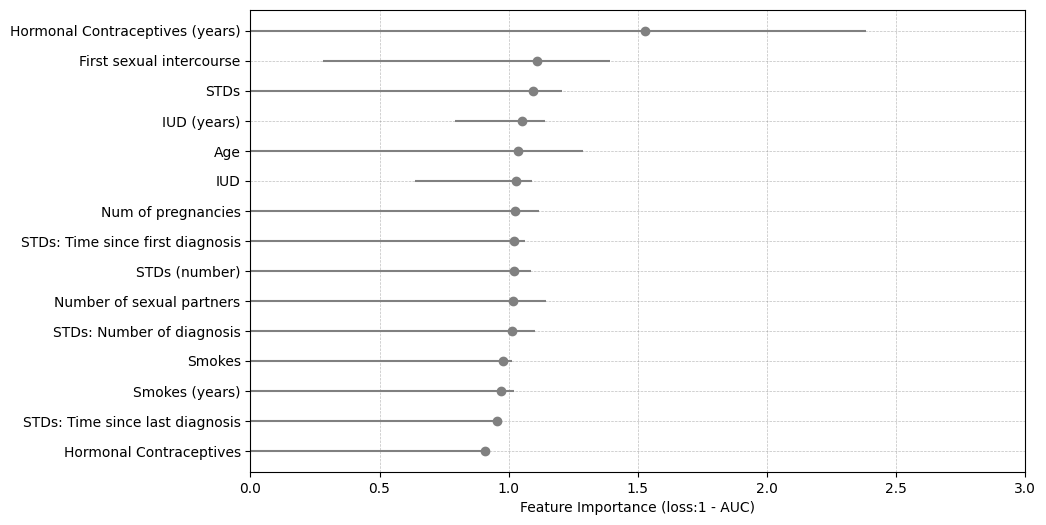

In [4]:
xerr = np.abs(
    np.stack(
        [
            (importance_df["permutation_min"] - importance_df["baseline"])
            / importance_df["permutation_std"],
            (importance_df["permutation_max"] - importance_df["baseline"])
            / importance_df["baseline"],
        ]
    )
)
x_values = (
    importance_df["permutation_mean"] - importance_df["baseline"]
) / importance_df["baseline"]

fig, ax = plt.subplots(figsize=(10, 6))


ax.errorbar(
    x=x_values + 1,
    y=importance_df["var_name"],
    xerr=xerr,
    fmt="o",
    color="gray",
)

ax.set_xlabel("Feature Importance (loss:1 - AUC)")
ax.grid(color="gray", linestyle="--", linewidth=0.5, alpha=0.5)
ax.set_xlim([0, 3])
plt.show()

In [5]:
from python.src.preprocess import (
    preprocess_bike_data,
)
from sklearn.svm import SVR

df_bike = pd.read_csv(config.data_dir / "bike-sharing-daily.csv")
df_bike_processed = preprocess_bike_data(df=df_bike)
assert df_bike.shape[0] == df_bike_processed.shape[0]
df_bike_processed["holiday"] = df_bike_processed["holiday"].map(
    {"HOLIDAY": 1, "NO HOLIDAY": 0}
)
df_bike_processed["season"] = df_bike_processed["season"].map(
    {
        "WINTER": 1,
        "SPRING": 2,
        "SUMMER": 3,
        "FALL": 4,
    }
)
df_bike_processed["workingday"] = df_bike_processed["workingday"].map(
    {"WORKING DAY": 1, "NO WORKING DAY": 0}
)
df_bike_processed["mnth"] = df_bike_processed["mnth"].map(
    {
        "JAN": 1,
        "FEB": 2,
        "MAR": 3,
        "APR": 4,
        "MAY": 5,
        "JUN": 6,
        "JUL": 7,
        "AUG": 8,
        "SEP": 9,
        "OCT": 10,
        "NOV": 11,
        "DEC": 12,
    }
)
df_bike_processed["weekday"] = df_bike_processed["weekday"].map(
    {
        "SUN": 1,
        "MON": 2,
        "TUE": 3,
        "WED": 4,
        "THU": 5,
        "FRI": 6,
        "SAT": 7,
    }
)
df_bike_processed["weathersit"] = df_bike_processed["weathersit"].map(
    {"MISTY": 1, "GOOD": 2, "RAIN/SNOW/STORM": 3}
)
X = df_bike_processed.drop(columns="cnt")
y = df_bike_processed["cnt"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=config.test_size, random_state=config.seed
)
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.fit_transform(X_test), columns=X_test.columns, index=X_test.index
)

svr = SVR()
svr.fit(X_train_scaled, y_train)

SVR()

In [6]:
from sklearn.metrics import mean_absolute_error

pfi = PermutationFeatureImportance(
    svr,
    X=X_test_scaled,
    y=y_test,
    metric=mean_absolute_error,
    pred_type="regression",
)
importance_df = pfi.permutation_feature_importance()

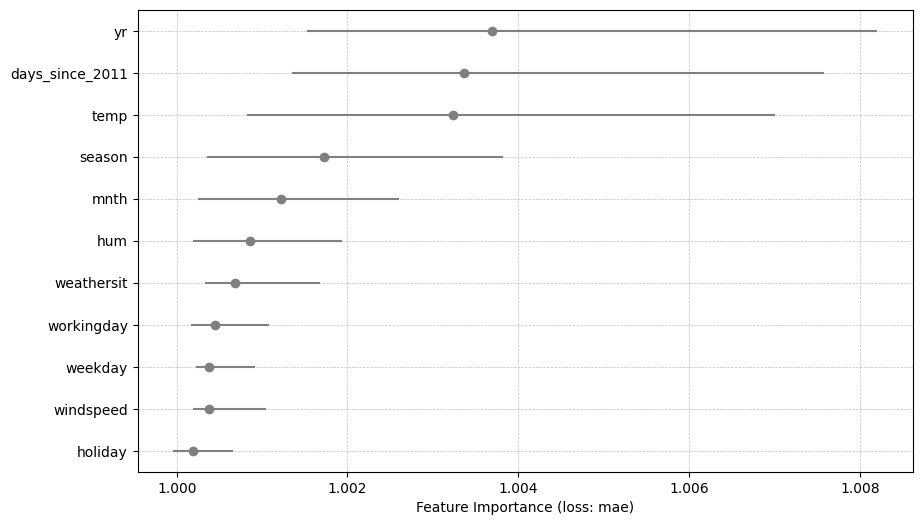

In [7]:
xerr = np.abs(
    np.stack(
        [
            (importance_df["permutation_min"] - importance_df["baseline"])
            / importance_df["baseline"],
            (importance_df["permutation_max"] - importance_df["baseline"])
            / importance_df["baseline"],
        ]
    )
)
x_values = (
    importance_df["permutation_mean"] - importance_df["baseline"]
) / importance_df["baseline"]

fig, ax = plt.subplots(figsize=(10, 6))
ax.errorbar(
    x=x_values + 1,
    y=importance_df["var_name"],
    xerr=xerr,
    fmt="o",
    color="gray",
)

ax.set_xlabel("Feature Importance (loss: mae)")
ax.grid(color="gray", linestyle="--", linewidth=0.5, alpha=0.5)
plt.show()